In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import sys
import os

# Add the parent directory to sys.path
sys.path.append(os.path.abspath(os.path.join('..')))

# 1. Load Raw Data

In [3]:
phish=pd.read_csv("../data/mp_malicious_normalised.csv")
phish.head()

,url,type,domain_age,domain_status
0,br-icloud.com.br,phishing,486,2
1,mp3raid.com/music/krizz_kaliko.html,benign,9214,2
2,bopsecrets.org/rexroth/cr/1.htm,benign,9234,2
3,http://www.garage-pirenne.be/index.php?option=...,defacement,28,2
4,http://adventure-nicaragua.net/index.php?optio...,defacement,160,2


In [4]:
phish.tail()

,url,type,domain_age,domain_status
168295,http://125.46.221.145:47991/Mozi.m,malware,0,0
168296,http://222.139.30.106:54863/Mozi.m,malware,0,0
168297,http://107.175.36.162/bins/hoho.arm5,malware,0,0
168298,http://cltmusic.com/wp-content/themes/gigawatt...,malware,366,2
168299,http://185.244.39.123/sparc,malware,0,0


# 2. Analyze Raw Data

In [5]:
phish['type'].value_counts()

type
benign        100500
defacement     29554
phishing       28318
malware         9928
Name: count, dtype: int64

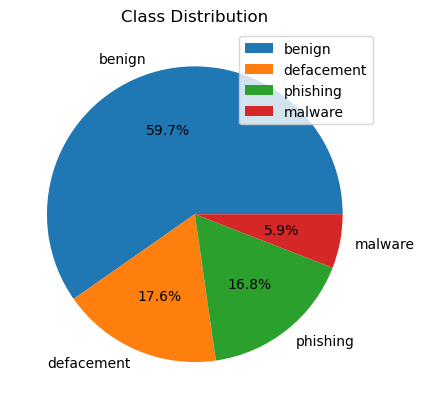

In [6]:
plt.pie(phish['type'].value_counts(), labels=['benign', 'defacement','phishing','malware'], autopct='%1.1f%%')
plt.title('Class Distribution')
plt.legend()
plt.show()

## 3. Data Processing

In [8]:
phish.isna().sum()

url              0
type             0
domain_age       0
domain_status    0
dtype: int64

### 3.1 Remove benign rows without domain info

In [23]:
phish = phish[~((phish['type'] == 'benign') & (phish['domain_age'] == 0))]
phish['type'].value_counts()

type
benign        91494
defacement    29554
phishing      28318
malware        9928
Name: count, dtype: int64

### 3.2 Remove duplicates

In [24]:
# Remove duplicates
phish = phish.drop_duplicates()

# Check for missing values and drop rows them
phish = phish.dropna()

# Drop empty type rows
phish = phish[phish['type'] != '']

# Verify the cleaned data
phish['type'].value_counts()

type
benign        91494
defacement    29554
phishing      28318
malware        9928
Name: count, dtype: int64

## 4. Feature Selection

### 4.1 Function to extract features from URLs

In [13]:
from modules.feature_engineering import feature_engineering
def extract_type(row_type):
    switcher = {
        'benign': 0,
        'defacement': 1,
        'phishing': 2,
        'malware': 3
    }
    return switcher.get(row_type.lower().strip(), -1)

def extract_features(row):
    features = {}
    features['type'] = extract_type(row['type'])
    features["domain_age"] = row["domain_age"]
    features["domain_status"] = row["domain_status"]
    features.update(feature_engineering(row['url']))
    return features
    

In [14]:

# Apply feature extraction to each row
features_list = phish.apply(extract_features, axis=1)

# Convert features into a DataFrame
final_df = pd.DataFrame(features_list.tolist())
final_df = final_df.dropna(how='any')
final_df.head()

,type,domain_age,domain_status,shortening_service,file_extension,domain_entropy,digits_count,queries_count,special_characters_count,suspicious_query,is_common_tld,domain_length,url_length,is_http,sensitive_words
0,2,486,2,0,0,3.375000,0,0,0,0,0,16,16,0,0
1,0,9214,2,0,5,3.277613,1,0,1,0,1,11,35,0,0
2,0,9234,2,0,5,3.235926,1,0,0,0,1,14,31,0,0
3,1,28,2,0,5,3.308751,7,49,9,0,1,21,88,1,0
4,1,160,2,0,5,3.501398,22,194,6,0,1,23,235,1,0


In [15]:
final_df.tail()

,type,domain_age,domain_status,shortening_service,file_extension,domain_entropy,digits_count,queries_count,special_characters_count,suspicious_query,is_common_tld,domain_length,url_length,is_http,sensitive_words
159289,3,0,0,0,0,3.903208,16,0,0,0,0,34,34,1,0
159290,3,0,0,0,0,4.079679,16,0,0,0,0,34,34,1,0
159291,3,0,0,0,0,4.183542,12,0,0,0,0,36,36,1,0
159292,3,366,2,0,5,3.022055,3,0,0,0,1,12,86,1,0
159293,3,0,0,0,0,3.958229,11,0,0,0,0,27,27,1,0


In [16]:
final_df.isna().sum()

type                        0
domain_age                  0
domain_status               0
shortening_service          0
file_extension              0
domain_entropy              0
digits_count                0
queries_count               0
special_characters_count    0
suspicious_query            0
is_common_tld               0
domain_length               0
url_length                  0
is_http                     0
sensitive_words             0
dtype: int64

In [17]:
final_df['type'].value_counts()

type
0    91494
1    29554
2    28318
3     9928
Name: count, dtype: int64

In [18]:
final_df['is_common_tld'].value_counts()

is_common_tld
1    136364
0     22930
Name: count, dtype: int64

## Save data

In [19]:
final_df.to_csv("../data/feature_engineered_data_mn.csv", index=False)

##

In [20]:
from sklearn.model_selection import train_test_split
X = final_df.drop('type', axis=1)
y = final_df['type']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [21]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report

classifier = RandomForestClassifier(
    class_weight="balanced", random_state=42, n_estimators=200)

classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)

In [22]:
print(
    f"Accuracy with Random Forest Classifier: {accuracy_score(y_test, y_pred):.4f}")
print("Classification Report with Random Forest Classifier:")
print(classification_report(y_test, y_pred))

Accuracy with Random Forest Classifier: 0.9441
Classification Report with Random Forest Classifier:
              precision    recall  f1-score   support

           0       0.95      0.98      0.97     18347
           1       0.94      0.99      0.97      5809
           2       0.91      0.78      0.84      5685
           3       0.98      0.90      0.94      2018

    accuracy                           0.94     31859
   macro avg       0.95      0.91      0.93     31859
weighted avg       0.94      0.94      0.94     31859

